In [42]:
import networkx
import pandas as pd

In [1]:
!wget https://snap.stanford.edu/data/twitch.zip

--2021-11-09 18:47:37--  https://snap.stanford.edu/data/twitch.zip
SSL_INIT
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2842994 (2,7M) [application/zip]
Saving to: ‘twitch.zip’

twitch.zip          100%[===================>]   2,71M   887KB/s    in 3,1s    

2021-11-09 18:47:41 (887 KB/s) - ‘twitch.zip’ saved [2842994/2842994]



In [2]:
!unzip twitch.zip

Archive:  twitch.zip
   creating: twitch/
   creating: twitch/DE/
  inflating: twitch/DE/musae_DE.json  
  inflating: twitch/DE/musae_DE_edges.csv  
  inflating: twitch/DE/musae_DE_target.csv  
   creating: twitch/ENGB/
  inflating: twitch/ENGB/musae_ENGB_edges.csv  
  inflating: twitch/ENGB/musae_ENGB_features.json  
  inflating: twitch/ENGB/musae_ENGB_target.csv  
   creating: twitch/ES/
  inflating: twitch/ES/musae_ES_edges.csv  
  inflating: twitch/ES/musae_ES_features.json  
  inflating: twitch/ES/musae_ES_target.csv  
   creating: twitch/FR/
  inflating: twitch/FR/musae_FR_edges.csv  
  inflating: twitch/FR/musae_FR_features.json  
  inflating: twitch/FR/musae_FR_target.csv  
   creating: twitch/PTBR/
  inflating: twitch/PTBR/musae_PTBR_edges.csv  
  inflating: twitch/PTBR/musae_PTBR_features.json  
  inflating: twitch/PTBR/musae_PTBR_target.csv  
   creating: twitch/RU/
  inflating: twitch/RU/musae_RU_edges.csv  
  inflating: twitch/RU/musae_RU_features.json  
  inflating: twitc

In [45]:
GRAPH_DIR = "twitch/DE"

In [46]:
edges = pd.read_csv(GRAPH_DIR + "/musae_DE_edges.csv")

In [47]:
edges

,from,to
0,0,9206
1,0,7787
2,0,2145
3,0,2684
4,0,7275
...,...,...
153133,2547,2092
153134,9461,2092
153135,9295,7802
153136,7436,9487


In [48]:
nodes = pd.read_csv(GRAPH_DIR + "/musae_DE_target.csv")

In [49]:
nodes

,id,days,mature,views,partner,new_id
0,37905227,2149,True,162078,False,5079
1,63102384,1574,True,1370,False,4281
2,109414094,1034,True,6043,False,992
3,84163849,1319,True,94298,True,9021
4,38240837,2137,True,2323,False,330
...,...,...,...,...,...,...
9493,123101102,895,True,128,False,4572
9494,40627165,2001,False,44,False,6355
9495,50643307,1784,True,2038,False,206
9496,38810779,2114,False,449,False,7695


In [50]:
import networkx as nx

In [51]:
Graphtype = nx.Graph()
G = nx.from_pandas_edgelist(edges, source='from', target='to', create_using=Graphtype)

In [1]:
import random

In [53]:
# Na podstawie Epidemic Modeling with Modified Small-World Networks, Jingxin Zhang

In [54]:
def beta_graph(n,k,beta):
    beta_graph = rewire(ring_lattice(n,k),beta)
    return beta_graph

def ring_lattice(n,k):
    ring_lattice = nx.Graph()
    ring_lattice.add_nodes_from([i for i in range(n)])
    for i in range(n):
        for j in range(int(k/2)):
            ring_lattice.add_edge(i,(i+j+1)%n)
    return ring_lattice

def rewire(graph, beta):
    n = graph.number_of_nodes()
    for edge in list(graph.edges()):
        if random.random() < beta:
            if edge[0] > edge[1]:
                if edge[0] - edge[1] < n/2:
                    node = edge[0]
                else:
                    node = edge[1]
            else:
                if edge[1] - edge[0] < n/2:
                    node = edge[1]
                else:
                    node = edge[0]
            choices = list(nx.non_neighbors(graph,node))
            graph.remove_edge(edge[0],edge[1])
            graph.add_edge(node, choices[random.randint(0,len(choices)-1)])
    return graph

In [205]:
def save_data_to_file(status,steps,name):
    df_status = pd.DataFrame(status,columns=["status"]).reset_index().rename(columns={"index":"node"})
    df_status.to_csv(f"./simulation_results/nodes_{name}_{steps}.csv",index=None)

In [206]:
def simulate_SIR(graph,k,p,T,name):
    n = graph.number_of_nodes()
    
    steps = 1
    status = [0]*n # status=O - suspectible
    days = [0]*n
    infected = []
    cum_infected_data = [0]
    infected_data = [0]
    
    infected = random.sample(list(graph.nodes()),k)
    infected_data.append(k)
    
    for v in infected:
        status[v] = 1 # status=1 - infected
        days[v] = T
        cum_infected_data[-1] = cum_infected_data[-1] + 1/n
        
    save_data_to_file(status,steps,name)
        
    while len(infected) > 0:
        steps += 1
        cum_infected_data.append(cum_infected_data[-1])
        new_infected = []
        
        for node in infected:
            for v in list(graph.neighbors(node)):
                if status[v] == 0 and random.random() < p:
                    new_infected.append(v)
                    status[v] = 1
                    days[v] = T
                    cum_infected_data[-1] = cum_infected_data[-1] + 1/n
            days[node] = days[node] - 1
            if days[node] < 1:
                infected.remove(node)
                status[node] = 2 # status=2 - recovered
                
        infected = infected + new_infected
        infected_data.append(len(infected))
        
        if steps % 5 == 0:
            save_data_to_file(status,steps,name)
            
    save_data_to_file(status,steps,name)
    
    return cum_infected_data, infected_data, steps

In [207]:
import time

In [208]:
start_time = time.time()
cum_infected, infected, steps = simulate_SIR(G,2,0.1,5,"twitch_de")
end_time = time.time()

In [209]:
end_time - start_time

2.6538379192352295

In [210]:
import matplotlib.pyplot as plt

In [211]:
steps

29

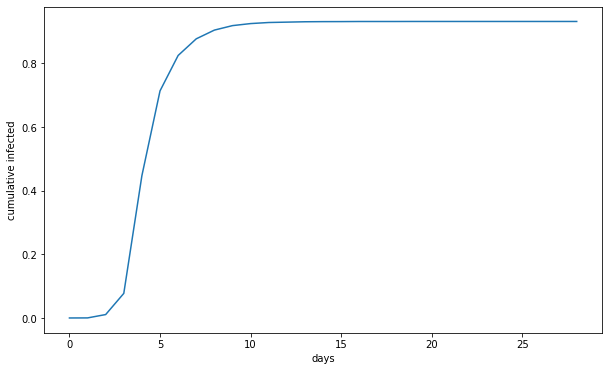

In [212]:
plt.figure(figsize=(10,6))
plt.plot(cum_infected)
plt.xlabel("days")
plt.ylabel("cumulative infected")
plt.show()

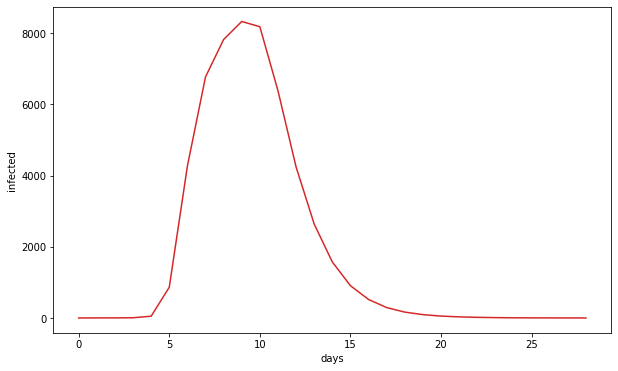

In [199]:
plt.figure(figsize=(10,6))
plt.plot(infected,c="tab:red")
plt.xlabel("days")
plt.ylabel("infected")
plt.show()